<a href="https://colab.research.google.com/github/cagdastopcu/omission-of-visual-stimuli/blob/main/Trying_to_get_meandFF_between_imag0_pres_JG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The usual import step:

In [193]:
!python -m pip install --upgrade pip
!pip install mindscope_utilities --upgrade

In [194]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# Here are the Allen packages:
import mindscope_utilities
import mindscope_utilities.visual_behavior_ophys as ophys
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

In [195]:
data_storage_directory = "/temp" # Note: this path must exist on your local drive
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_storage_directory)

# Setup the tables for the sessions and experiments:
session_table = cache.get_ophys_session_table()
experiment_table = cache.get_ophys_experiment_table()

we want this 'full_etr' dataset:

In [225]:
def get_cell_type_index(cell_type,session_table):

    """Get the indexes of the Allen sessions that use a particular cre line.
    
    Args:
      cell_type:  a string of the name of the cre line you want. This uses regex so you can try to be less descriptive, like 'sst' is good enoguh for Sst-IRES-cre.
      session_table: The table containing the sessions from Allen.

    Returns:
      ix (1D array): An index of sessions that use that cre line.
    """

    # Look through the cre_line collumn and see if the cell_type string is contained in the output, then write down the index.
    ix = session_table[session_table.cre_line.str.contains(cell_type,regex=True)].index

    return ix

test_ix = get_cell_type_index('Vip',session_table)
print(test_ix)

Int64Index([792619807, 794918442, 795625712, 796044280, 796236521, 798007990,
            825682242, 829521794, 830148632, 831761261,
            ...
            807055274, 808092249, 809261351, 960475393, 961180142, 961665529,
            962736894, 963496285, 964660947, 965319434],
           dtype='int64', name='ophys_session_id', length=148)


In [226]:
ophys_session_id = test_ix[0]
session_table.loc[ophys_session_id]

experiments = {}
ophys_experiment_ids = session_table.loc[ophys_session_id]['ophys_experiment_id']
for ophys_experiment_id in ophys_experiment_ids:
    experiments[ophys_experiment_id] = cache.get_behavior_ophys_experiment(ophys_experiment_id)


behavior_ophys_experiment_792815735.nwb:   0%|          | 0.00/320M [00:00<?, ?MB/s]
behavior_ophys_experiment_792815735.nwb:   0%|          | 1.02k/320M [00:00<14:16:09, 6.23kMB/s]
behavior_ophys_experiment_792815735.nwb:   0%|          | 173k/320M [00:00<10:00:02, 8.89kMB/s] 
behavior_ophys_experiment_792815735.nwb:   1%|          | 1.62M/320M [00:00<6:58:15, 12.7kMB/s]
behavior_ophys_experiment_792815735.nwb:   2%|▏         | 5.67M/320M [00:00<4:49:05, 18.1kMB/s]
behavior_ophys_experiment_792815735.nwb:   3%|▎         | 9.95M/320M [00:00<3:19:38, 25.9kMB/s]
behavior_ophys_experiment_792815735.nwb:   4%|▍         | 13.8M/320M [00:00<2:18:03, 37.0kMB/s]
behavior_ophys_experiment_792815735.nwb:   6%|▌         | 17.9M/320M [00:00<1:35:23, 52.8kMB/s]
behavior_ophys_experiment_792815735.nwb:   7%|▋         | 21.2M/320M [00:00<1:06:04, 75.4kMB/s]
behavior_ophys_experiment_792815735.nwb:   8%|▊         | 24.5M/320M [00:01<45:48, 108kMB/s]   
behavior_ophys_experiment_792815735.nwb:   9%|▉ 

In [198]:
neural_data = []
for ophys_experiment_id in tqdm(experiments.keys()): #tqdm is a package that shows progress bars for items that are iterated over
    this_experiment = experiments[ophys_experiment_id]
    this_experiment_neural_data = ophys.build_tidy_cell_df(this_experiment)
    
    # add some columns with metadata for the experiment
    metadata_keys = [
        'ophys_experiment_id',
        'ophys_session_id',
        'targeted_structure',
        'imaging_depth',
        'equipment_name',
        'cre_line',
        'mouse_id',
        'sex',
    ]
    for metadata_key in metadata_keys:
        this_experiment_neural_data[metadata_key] = this_experiment.metadata[metadata_key]
        
    # append the data for this experiment to a list
    neural_data.append(this_experiment_neural_data)
    
# concatate the list of dataframes into a single dataframe
neural_data = pd.concat(neural_data)

neural_data


100%|██████████| 7/7 [00:41<00:00,  5.95s/it]


,timestamps,dff,events,filtered_events,cell_roi_id,cell_specimen_id,ophys_experiment_id,ophys_session_id,targeted_structure,imaging_depth,equipment_name,cre_line,mouse_id,sex
0,9.26356,0.936573,0.000000,0.000000,1080743723,1086613265,951980471,951410079,VISp,150,MESO.1,Sst-IRES-Cre,457841,F
1,9.35677,0.582486,0.000000,0.000000,1080743723,1086613265,951980471,951410079,VISp,150,MESO.1,Sst-IRES-Cre,457841,F
2,9.44998,1.296005,0.556873,0.185215,1080743723,1086613265,951980471,951410079,VISp,150,MESO.1,Sst-IRES-Cre,457841,F
3,9.54318,0.844898,0.000000,0.163452,1080743723,1086613265,951980471,951410079,VISp,150,MESO.1,Sst-IRES-Cre,457841,F
4,9.63639,1.181188,0.467264,0.267750,1080743723,1086613265,951980471,951410079,VISp,150,MESO.1,Sst-IRES-Cre,457841,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48311,4513.50871,2.012210,0.000000,0.295667,1080742704,1086612827,951980486,951410079,VISl,300,MESO.1,Sst-IRES-Cre,457841,F
48312,4513.60195,2.238623,0.513076,0.326969,1080742704,1086612827,951980486,951410079,VISl,300,MESO.1,Sst-IRES-Cre,457841,F
48313,4513.69518,1.749840,0.000000,0.219440,1080742704,1086612827,951980486,951410079,VISl,300,MESO.1,Sst-IRES-Cre,457841,F
48314,4513.78842,1.868406,0.416648,0.266907,1080742704,1086612827,951980486,951410079,VISl,300,MESO.1,Sst-IRES-Cre,457841,F


In [199]:
stimulus_table = experiments[ophys_experiment_ids[0]].stimulus_presentations
stimulus_table

,duration,end_frame,image_index,image_name,image_set,index,omitted,start_frame,start_time,stop_time,is_change
stimulus_presentations_id,,,,,,,,,,,
0,0.25020,18001.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,0,False,17986,309.27537,309.52557,False
1,0.25021,18046.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,1,False,18031,310.02598,310.27619,False
2,0.25020,18091.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,2,False,18076,310.77660,311.02680,False
3,0.25019,18136.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,3,False,18121,311.52721,311.77740,False
4,0.25024,18181.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,4,False,18166,312.27782,312.52806,False
...,...,...,...,...,...,...,...,...,...,...,...
4796,0.25020,233857.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,4628,False,233842,3909.81737,3910.06757,False
4797,0.25021,233902.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,4629,False,233887,3910.56798,3910.81819,False
4798,0.25020,233947.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,4630,False,233932,3911.31860,3911.56880,False


In [200]:
full_etr = []
# iterate over each unique cell
for cell_specimen_id in tqdm(neural_data['cell_specimen_id'].unique()):
    # calculate the event triggered response for this cell to every stimulus
    full_etr_this_cell = mindscope_utilities.event_triggered_response(
        neural_data.query('cell_specimen_id == @cell_specimen_id'),
        t = 'timestamps',
        y = 'dff',
        event_times = stimulus_table['start_time'],
        t_before = 0,
        t_after = 0.75,
        output_sampling_rate = 30 
    )
    # add a column identifying the cell_specimen_id
    full_etr_this_cell['cell_specimen_id'] = cell_specimen_id
    # append to our list
    full_etr.append(full_etr_this_cell)

# concatenate our list of dataframes into a single dataframe
full_etr = pd.concat(full_etr)

# cast these numeric columns to int and float, respectively 
full_etr['event_number'] = full_etr['event_number'].astype(int)
full_etr['event_time'] = full_etr['event_number'].astype(float)
full_etr.rename(columns = {'event_time': 'stimulus_presentations_id'}, inplace=True)


100%|██████████| 88/88 [05:40<00:00,  3.86s/it]


In [201]:
full_etr

,time,dff,event_number,stimulus_presentations_id,cell_specimen_id
0,0.000000,1.017334,0,0.0,1086613265
1,0.034091,1.017334,0,0.0,1086613265
2,0.068182,1.017334,0,0.0,1086613265
3,0.102273,1.022310,0,0.0,1086613265
4,0.136364,1.029972,0,0.0,1086613265
...,...,...,...,...,...
110418,0.613636,0.021896,4800,4800.0,1086612827
110419,0.647727,-0.006772,4800,4800.0,1086612827
110420,0.681818,0.012321,4800,4800.0,1086612827
110421,0.715909,0.031414,4800,4800.0,1086612827


In [202]:
average_responses = full_etr.groupby(['cell_specimen_id','stimulus_presentations_id'])[['dff']].mean().reset_index().merge(
    stimulus_table,
    on = 'stimulus_presentations_id',
    how = 'left'
)
average_responses

,cell_specimen_id,stimulus_presentations_id,dff,duration,end_frame,image_index,image_name,image_set,index,omitted,start_frame,start_time,stop_time,is_change
0,1086606974,0.0,-0.644137,0.25020,18001.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,0,False,17986,309.27537,309.52557,False
1,1086606974,1.0,-0.104356,0.25021,18046.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,1,False,18031,310.02598,310.27619,False
2,1086606974,2.0,-0.043796,0.25020,18091.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,2,False,18076,310.77660,311.02680,False
3,1086606974,3.0,0.162058,0.25019,18136.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,3,False,18121,311.52721,311.77740,False
4,1086606974,4.0,0.052421,0.25024,18181.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,4,False,18166,312.27782,312.52806,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422483,1086623929,4796.0,0.013520,0.25020,233857.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,4628,False,233842,3909.81737,3910.06757,False
422484,1086623929,4797.0,0.010339,0.25021,233902.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,4629,False,233887,3910.56798,3910.81819,False
422485,1086623929,4798.0,-0.038199,0.25020,233947.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,4630,False,233932,3911.31860,3911.56880,False
422486,1086623929,4799.0,0.016099,0.25018,233992.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,4631,False,233977,3912.06921,3912.31939,False


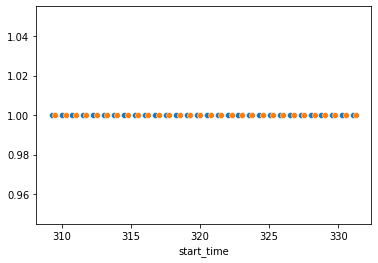

In [203]:

sns.scatterplot(y =np.ones(30), x= average_responses.start_time[:30])
sns.scatterplot(y =np.ones(30), x= average_responses.stop_time[:30])


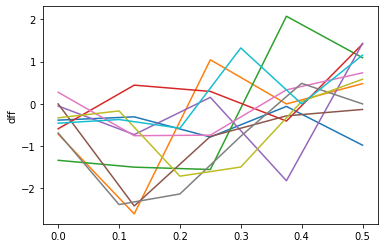

In [204]:
timepad = 3; # seconds

cells = average_responses.cell_specimen_id.unique()
past = sns.color_palette("pastel",len(cells))

cc = -1
for c in cells[:1]:
  cc+=1
  subset = average_responses[(average_responses['cell_specimen_id'] == c) & (average_responses['omitted'].astype(bool) == False)]
  subset.head()
  nd = neural_data[(neural_data['cell_specimen_id'] == c)]

  holder = [];
  #for i in range(len(subset.start_time.unique())-1):
  for i in range(10):
    t2 = subset.stop_time.iloc[i]+.50
    t1 = subset.stop_time.iloc[i]
    dff = []
    dff = nd.dff[(nd.timestamps >= t1) & (nd.timestamps <= t2)]
    t = np.linspace(
                t1,
                t2,
                len(dff)
            )
    
    sns.lineplot(x = t - min(t), y =dff)


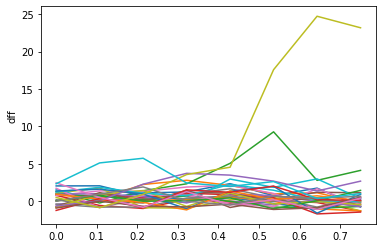

In [205]:
cells = average_responses.cell_specimen_id.unique()
past = sns.color_palette("pastel",len(cells))

timepad = 1

cc = -1
for c in cells[:1]:
  cc+=1
  subset = average_responses[(average_responses['cell_specimen_id'] == c) & (average_responses['omitted'].astype(bool) == True)]
  nd = neural_data[(neural_data['cell_specimen_id'] == c)]

  holder = [];
  #for i in range(len(subset.start_time.unique())-1):
  for i in range(30):
    t2 = subset.stop_time.iloc[i]+.75
    t1 = subset.stop_time.iloc[i]
    dff = []
    dff = nd.dff[(nd.timestamps >= t1) & (nd.timestamps <= t2)]
    t = np.linspace(
                t1,
                t2,
                len(dff)
            )
    
    sns.lineplot(x = t -min(t), y =dff)


In [207]:
def get_mean_gray_resp(average_responses,neural_data,c):
  '''
  This function returns the mean change in fluorescence in the periods between image presentations.

   Args:
      average_responses: A linked database.
      average_responses = full_etr.groupby(['cell_specimen_id','stimulus_presentations_id'])[['dff']].mean().reset_index().merge(
      stimulus_table,
      on = 'stimulus_presentations_id',
      how = 'left'
      )

      session_table: The extracted neural data.

      c: the cell id.

    Returns:
    np.mean(holder) 
    np.std(holder)

    holder holds all the dff data for the cell, concatenated. 
      
    """
  '''
  subset = average_responses[(average_responses['cell_specimen_id'] == c) & (average_responses['omitted'] == True)]
  nd = neural_data[(neural_data['cell_specimen_id'] == c)]

  holder = []

  for i in range(len(subset.start_time.unique())-1):
    t2 = subset.stop_time.iloc[i]+.50
    t1 = subset.stop_time.iloc[i]
    dff = nd.dff[(nd.timestamps >= t1) & (nd.timestamps <= t2)]
    holder = np.concatenate([holder, dff.to_numpy().T], axis=0)

  return np.mean(holder), np.std(holder), len(subset.start_time.unique())

cells = average_responses.cell_specimen_id.unique()
a,b,c = get_mean_gray_resp(average_responses,neural_data,cells[1])

print(a)
print(b)

-0.024353452175217838
0.11115252053659486


In [208]:
def make_neural_data(ophys_experiment_id):
  neural_data = []
  this_experiment = experiments[ophys_experiment_id]
  this_experiment_neural_data = ophys.build_tidy_cell_df(this_experiment)
  
  # add some columns with metadata for the experiment
  metadata_keys = [
      'ophys_experiment_id',
      'ophys_session_id',
      'targeted_structure',
      'imaging_depth',
      'equipment_name',
      'cre_line',
      'mouse_id',
      'sex',
  ]
  for metadata_key in metadata_keys:
      this_experiment_neural_data[metadata_key] = this_experiment.metadata[metadata_key]
      
  # append the data for this experiment to a list
  neural_data.append(this_experiment_neural_data)
    
  # concatate the list of dataframes into a single dataframe
  neural_data = pd.concat(neural_data)

  return neural_data

nd = make_neural_data(ophys_experiment_ids[1])
nd.head()

,timestamps,dff,events,filtered_events,cell_roi_id,cell_specimen_id,ophys_experiment_id,ophys_session_id,targeted_structure,imaging_depth,equipment_name,cre_line,mouse_id,sex
0,9.26356,0.495924,0.0,0.0,1080744295,1086620813,951980473,951410079,VISp,225,MESO.1,Sst-IRES-Cre,457841,F
1,9.35677,0.000000,0.0,0.0,1080744295,1086620813,951980473,951410079,VISp,225,MESO.1,Sst-IRES-Cre,457841,F
2,9.44998,0.377344,0.0,0.0,1080744295,1086620813,951980473,951410079,VISp,225,MESO.1,Sst-IRES-Cre,457841,F
3,9.54318,0.300545,0.0,0.0,1080744295,1086620813,951980473,951410079,VISp,225,MESO.1,Sst-IRES-Cre,457841,F
4,9.63639,0.137573,0.0,0.0,1080744295,1086620813,951980473,951410079,VISp,225,MESO.1,Sst-IRES-Cre,457841,F


In [209]:
def make_average_response(neural_data,stimulus_table):
  full_etr = []
  # iterate over each unique cell
  for cell_specimen_id in tqdm(neural_data['cell_specimen_id'].unique()):
      # calculate the event triggered response for this cell to every stimulus
      full_etr_this_cell = mindscope_utilities.event_triggered_response(
          neural_data.query('cell_specimen_id == @cell_specimen_id'),
          t = 'timestamps',
          y = 'dff',
          event_times = stimulus_table['start_time'],
          t_before = 0,
          t_after = 0.75,
          output_sampling_rate = 30 
      )
      # add a column identifying the cell_specimen_id
      full_etr_this_cell['cell_specimen_id'] = cell_specimen_id
      # append to our list
      full_etr.append(full_etr_this_cell)

  # concatenate our list of dataframes into a single dataframe
  full_etr = pd.concat(full_etr)

  # cast these numeric columns to int and float, respectively 
  full_etr['event_number'] = full_etr['event_number'].astype(int)
  full_etr['event_time'] = full_etr['event_number'].astype(float)
  full_etr.rename(columns = {'event_time': 'stimulus_presentations_id'}, inplace=True)

  average_responses = full_etr.groupby(['cell_specimen_id','stimulus_presentations_id'])[['dff']].mean().reset_index().merge(
    stimulus_table,
    on = 'stimulus_presentations_id',
    how = 'left'
  )

  return average_responses

ar = make_average_response(nd,stimulus_table)
ar.head()


100%|██████████| 12/12 [00:46<00:00,  3.86s/it]


,cell_specimen_id,stimulus_presentations_id,dff,duration,end_frame,image_index,image_name,image_set,index,omitted,start_frame,start_time,stop_time,is_change
0,1086620813,0.0,0.056831,0.25020,18001.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,0,False,17986,309.27537,309.52557,False
1,1086620813,1.0,0.123316,0.25021,18046.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,1,False,18031,310.02598,310.27619,False
2,1086620813,2.0,-0.051323,0.25020,18091.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,2,False,18076,310.77660,311.02680,False
3,1086620813,3.0,-0.003181,0.25019,18136.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,3,False,18121,311.52721,311.77740,False
4,1086620813,4.0,-0.001767,0.25024,18181.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,4,False,18166,312.27782,312.52806,False


In [210]:
def get_mean_omission_resp(average_responses,neural_data,c):
  '''
  This function returns the mean change in fluorescence in the periods between image presentations.

   Args:
      average_responses: A linked database.
      average_responses = full_etr.groupby(['cell_specimen_id','stimulus_presentations_id'])[['dff']].mean().reset_index().merge(
      stimulus_table,
      on = 'stimulus_presentations_id',
      how = 'left'
      )

      session_table: The extracted neural data.

      c: the cell id.

    Returns:
    np.mean(holder) 
    np.std(holder)

    holder holds all the dff data for the cell, concatenated. 
      
    """
  '''
  subset = average_responses[(average_responses['cell_specimen_id'] == c) & (average_responses['omitted'] == True)]
  nd = neural_data[(neural_data['cell_specimen_id'] == c)]

  holder = []

  for i in range(len(subset.start_time.unique())-1):
    t2 = subset.stop_time.iloc[i]+.75
    t1 = subset.stop_time.iloc[i]
    dff = nd.dff[(nd.timestamps >= t1) & (nd.timestamps <= t2)]
    holder = np.concatenate([holder, dff.to_numpy().T], axis=0)

  return np.mean(holder), np.std(holder), len(subset.start_time.unique())

print(get_mean_omission_resp(average_responses,neural_data,cells[0]))

(0.6072204961123178, 2.527831113783023, 168)


Okay, putting it all together...

In [218]:
cells = ar.cell_specimen_id.unique()
for c in range(len(cells)):
  m_gray,b = get_mean_gray_resp(ar,nd,cells[c])
  m_om,b = get_mean_omission_resp(ar,nd,cells[c])
  d = nd['imaging_depth'][0]
  sns.scatterplot(x = d, y = m_om-m_gray)

ValueError: ignored

In [ ]:
holder = [];
for j in range(len(test_ix)):
  ophys_session_ids = test_ix[j]
  for i in range(len(ophys_experiment_ids)):
    experiments = {}

    ophys_experiment_ids = session_table.loc[ophys_session_id]['ophys_experiment_id']
    for ophys_experiment_id in ophys_experiment_ids:
        experiments[ophys_experiment_id] = cache.get_behavior_ophys_experiment(ophys_experiment_id)

    stimulus_table = experiments[ophys_experiment_ids[i]].stimulus_presentations
    nd = make_neural_data(ophys_experiment_ids[i])
    ar = make_average_response(nd,stimulus_table)

    cells = ar.cell_specimen_id.unique()
    for c in range(len(cells)):
    #for c in range(10):
      m_gray,s_gray,n_gray = get_mean_gray_resp(ar,nd,cells[c])
      m_om,s_om,n_om = get_mean_omission_resp(ar,nd,cells[c])
      d = nd['imaging_depth'][0]
      sns.scatterplot( x = d, y = ((m_om-m_gray)/np.sqrt((s_gray**2)/n_gray + (s_om**2)/n_om)) )
      holder.append([m_gray,s_gray,n_gray,m_om,s_om,n_om,d])
      print(holder)



  0%|          | 0/27 [00:00<?, ?it/s]

  4%|▎         | 1/27 [00:04<01:45,  4.06s/it]

  7%|▋         | 2/27 [00:07<01:40,  4.01s/it]

 11%|█         | 3/27 [00:11<01:34,  3.95s/it]

 15%|█▍        | 4/27 [00:16<01:33,  4.06s/it]

 19%|█▊        | 5/27 [00:20<01:28,  4.02s/it]

 22%|██▏       | 6/27 [00:23<01:23,  3.98s/it]

 26%|██▌       | 7/27 [00:27<01:18,  3.91s/it]

 30%|██▉       | 8/27 [00:31<01:14,  3.92s/it]

 33%|███▎      | 9/27 [00:35<01:09,  3.88s/it]

 37%|███▋      | 10/27 [00:39<01:05,  3.87s/it]

 41%|████      | 11/27 [00:43<01:02,  3.90s/it]

 44%|████▍     | 12/27 [00:47<00:58,  3.91s/it]

 48%|████▊     | 13/27 [00:50<00:54,  3.90s/it]

 52%|█████▏    | 14/27 [00:54<00:50,  3.88s/it]

 56%|█████▌    | 15/27 [00:58<00:46,  3.90s/it]

 59%|█████▉    | 16/27 [01:02<00:42,  3.90s/it]

 63%|██████▎   | 17/27 [01:06<00:39,  3.92s/it]

 67%|██████▋   | 18/27 [01:10<00:35,  3.94s/it]

 70%|███████   | 19/27 [01:14<00:31,  3.94s/it]

 74%|███████▍  | 20/27 [01:18<00:27,